# Charting the cost of owning a new home in the UK

An examination of the yearly cost of a new mortgage in the UK since 2005 with the average cost of running a petrol car and average energy bills factored in. An exercise in data science which includes the use of regexes and matplotlib. I wanted to see if there was any correlation between now (July 2023) and 2008 when the last pre-COVID recession occurred. 

# Module Imports
First the required libraries are imported

In [966]:
import pandas as pd
import numpy as np
import re
import piplite
await piplite.install('seaborn')
import matplotlib.pyplot as plt
import seaborn as sns
%pip install xlrd
%pip install openpyxl

# Reading the Data

The data sets were primarily sourced from the Office of National Statistics and Ofgem. The files are read as Pandas Dataframes

In [967]:
# Each dataframe had some rows that required skipping so as to noramalise index and column
# Some column names were coerced so to be preset with the names parameter
avg_house_prices_2005on = pd.read_excel('assets/AverageHousePrices_2005to2023.xls', skiprows=6, names=['Dates', 'UK_average_house_price'])
mortgage_rates = pd.read_excel('assets/MortgageRates.xlsx', skiprows=4)
petrol_prices = pd.read_excel('assets/ONS_UNPetrol_Prices_Since_1990.xls', skiprows=7, names=['Date', 'Pence Per Litre'])
petrol_car_efficiency = pd.read_excel('assets/DfT Fuel Consumption.xlsx', skiprows=6, skipfooter=13)
average_weekly_earnings = pd.read_excel('assets/Average_WeeklyEarnings_since2000_ONS.xls', skiprows=6)
average_energy_bills = pd.read_excel('assets/Ofgem_retail-price-comparison.xlsx')

# The functions are set

The functions are set at the beginning of the code as per convention. 

In [968]:
# Function to figure the monthly interest rate for the mortgage formula
def monthly_VR(rate): 
    rate = rate / 100 / 12
    return rate

In [969]:
# Function to figure the percentage change in yearly values for graph plot
def change_percentage(dataframe, column):
    new_values = [dataframe[column][i] for i in range(0, len(dataframe))]
    final_values = [(new_values[i] - new_values[i-1]) / new_values[i-1] * 100 for i in range(0, len(new_values))]
    # added a zero here for the negative indexing result of the list comprehension. 
    final_values[0] = 0
    d = {column: final_values}            
    new_dataframe = pd.DataFrame(d)
    s = pd.Series(np.arange(2005,2024,1))
    new_dataframe = new_dataframe.set_index(s)
    
    return new_dataframe

In [970]:
# The variable for kilometers per year, the same as 6800 miles
av_km_per_year = 10943.54

# Data Cleaning and Preperation

The average house prices data is cleaned and prepared for the evaluation starting at year 2005. Average house prices were one of the factors of calculating the variable mortgage rate cost. 

In [971]:
# Data prepared for reading the Dates, Pandas datetime. 
avg_house_prices_2005on['Dates'] = pd.to_datetime(avg_house_prices_2005on['Dates'])
avg_house_prices_2005on['Dates'] = avg_house_prices_2005on['Dates'].dt.year
avg_house_prices_2005on = avg_house_prices_2005on.rename(columns={'Dates' : 'Year'})
avg_house_prices_2005on = avg_house_prices_2005on.groupby("Year").mean()

Pandas dataframs .head() function is a good way to check the status and colums of a dataframe.

In [972]:
avg_house_prices_2005on.head()

,UK_average_house_price
Year,
2005,156236.250000
2006,168513.000000
2007,185196.333333
2008,176852.750000
2009,161147.916667


The mortgage rate chages were also factored, the choice was for variable rate to be better indicative of base rate changes. 

In [973]:
# Assuming 'date' column is of type '<class 'datetime.datetime'>'
mortgage_rates['date'] = pd.to_datetime(mortgage_rates['date'])  # Convert to pandas datetime
# Accessing the 'year' attribute
mortgage_rates['date'] = mortgage_rates['date'].dt.year
mortgage_rates = mortgage_rates.rename(columns={'date': 'Year', 'Mortgages of which variable rate': 'Variable Rate', 'Mortgages of which fixed rate': 'Fixed Rate'})
mortgage_rates = mortgage_rates.loc[mortgage_rates['Year'] >= 2005]
mortgage_rates = mortgage_rates.groupby("Year").mean()

Petrol car efficiency was considered in working out the average cost of running a car. The data presumes registered vehicles, so buyer choice is factored in. 


In [974]:
# The dataframe requied transposing
petrol_car_efficiency = petrol_car_efficiency.T.reset_index()
petrol_car_efficiency = petrol_car_efficiency[14:].rename(columns={0 : "Av Liters/100KM"})
petrol_car_efficiency = petrol_car_efficiency[['index','Av Liters/100KM']]
petrol_car_efficiency = petrol_car_efficiency.rename(columns={'index' : 'Year'})
petrol_car_efficiency.loc[29, 'Year'] = 2020
petrol_car_efficiency = pd.DataFrame(petrol_car_efficiency)
petrol_years = pd.DataFrame([[2021, 5.37], [2022, 5.30], [2023, 5.3]], columns=['Year', 'Av Liters/100KM'])
petrol_car_efficiency = pd.concat([petrol_car_efficiency, petrol_years], ignore_index=True)

# The head of th petrol_car_efficiency dataframe

petrol_car_efficiency.head()

,Year,Av Liters/100KM
0,2005,7.42
1,2006,7.26
2,2007,7.13
3,2008,6.86
4,2009,6.41


In [975]:
# And the length of the index
len(petrol_car_efficiency.index)

19

Petrol costs were factored in in order to ascertain the average cost of running a car per month assuming 6800 miles per year.

In [976]:
# The search after the index after which data is more concise for year.
petrol_prices = petrol_prices.loc[345:]
# Integers convereted to datetime so as to further examine.
petrol_prices['Date'] = pd.to_datetime(petrol_prices['Date'])
petrol_prices['Date'] = petrol_prices['Date'].dt.year
# Date column renamed "Year" in preparation for the dataframe merge later.
petrol_prices = petrol_prices.rename(columns={'Date': 'Year'})
petrol_prices = petrol_prices.groupby("Year").mean()

Pandas dataframes .shape is a useful function to understand the shape of a dataframe.

In [977]:
# An example of the shape of petrol_prices
petrol_prices.shape

(19, 1)

The average weekly earnings are figured and converted to a yearly average. Great the length of the petrol_prices is the same as petrol car efficiency, so less work to do later when it comes to merging or plotting. 

Average weekly earnings before cleaning and sorting the data so that it is similar in shape and type to the previous two dataframes. There are 280 rows so some work still to do. 

In [978]:
average_weekly_earnings

,Period,Total pay,Regular pay
0,Jan 2000,307,293
1,Feb 2000,300,293
2,Mar 2000,310,293
3,Apr 2000,310,293
4,May 2000,312,294
...,...,...,...
275,Dec 2022,632,589
276,Jan 2023,634,591
277,Feb 2023,640,596
278,Mar 2023,645,599


We're after the Total Pay and the Period needs to be just in years so that they are comparible to the other data.

In [979]:
# A regex is required in order to prepare the date data to years. 
pattern = r'(\D+)(?=\d)'
average_weekly_earnings['Period'] = average_weekly_earnings['Period'].str.replace(pattern, '', regex=True)
# The dataframe is grouped by year so as to find the yearly average. 
average_weekly_earnings = average_weekly_earnings.groupby('Period').mean()
average_weekly_earnings['Yearly Pay'] = average_weekly_earnings['Total pay'] * 52
# A new dataframe is created with the correct name for propriety. 
average_yearly_earnings = average_weekly_earnings.drop(columns=['Total pay', 'Regular pay'])

The Yearly Pay column has been added and the 'Total Pay' and 'Regular Pay' has been dropped, the Periods now show the average yearly wage.  

The average energy bills data is cleaned and prepared so as to be aligned with other data that is part of the code. 

In [980]:
average_energy_bills = average_energy_bills[['\n', 'Average standard variable tariff (Large legacy suppliers)']]
# Convert '\n' column to datetime format and extract year in order to groupby
average_energy_bills['\n'] = pd.to_datetime(average_energy_bills['\n'], format='%Y-%m-%d')
average_energy_bills['Year'] = average_energy_bills['\n'].dt.year
average_energy_bills.drop(columns=['\n'], inplace=True)
# Some columns are renamed so as to make the dataframe readable
average_energy_bills = average_energy_bills.groupby('Year').mean()
average_energy_bills
average_energy_bills = average_energy_bills.rename(columns={"Average standard variable tariff (Large legacy suppliers)" : "Average Energy Bills"})

# A New Dataframe

A new dataframe is created for the purpose of merging


In [981]:
df = pd.merge(avg_house_prices_2005on, mortgage_rates, left_on='Year', right_on='Year', how='left')
df = pd.merge(df, petrol_prices, left_on='Year', right_on='Year', how='left')
df = pd.merge(df, petrol_car_efficiency, left_on='Year', right_on='Year', how='left' )
df = pd.merge(df, average_energy_bills, left_on='Year', right_on='Year', how='left')


Average mortgage costs are calculated, formula: M = P * (r * (1 + r)**n) / ((1 + r)**n - 1)

In [982]:
# Mortgage repayement calculated for new column
df['Avg VR Mortgage Cost'] = ((df['UK_average_house_price'] - (df['UK_average_house_price'] / 10)) * (monthly_VR(df['Variable Rate']) * (1 + monthly_VR(df['Variable Rate'])) ** 300) / (((1 + monthly_VR(df['Variable Rate'])) ** 300) - 1)) * 12

Petrol spend is factored and added as a column to the new dataframe.

In [983]:
df['Petrol Spend£'] = (av_km_per_year / 100) * df['Av Liters/100KM'] * (df['Pence Per Litre'] / 100)

Lastly, average yearly paid is added as a new column to the main dataframe "df"

In [984]:
df['Average Yearly Pay'] = list(average_weekly_earnings.loc['2005': '2023', 'Yearly Pay'])

The yearly change in averages are prepared so as to be plotted

# Plotting the first graph

The data has been cleared and prepared in a new dataframe now to be used to plot the first graph. 

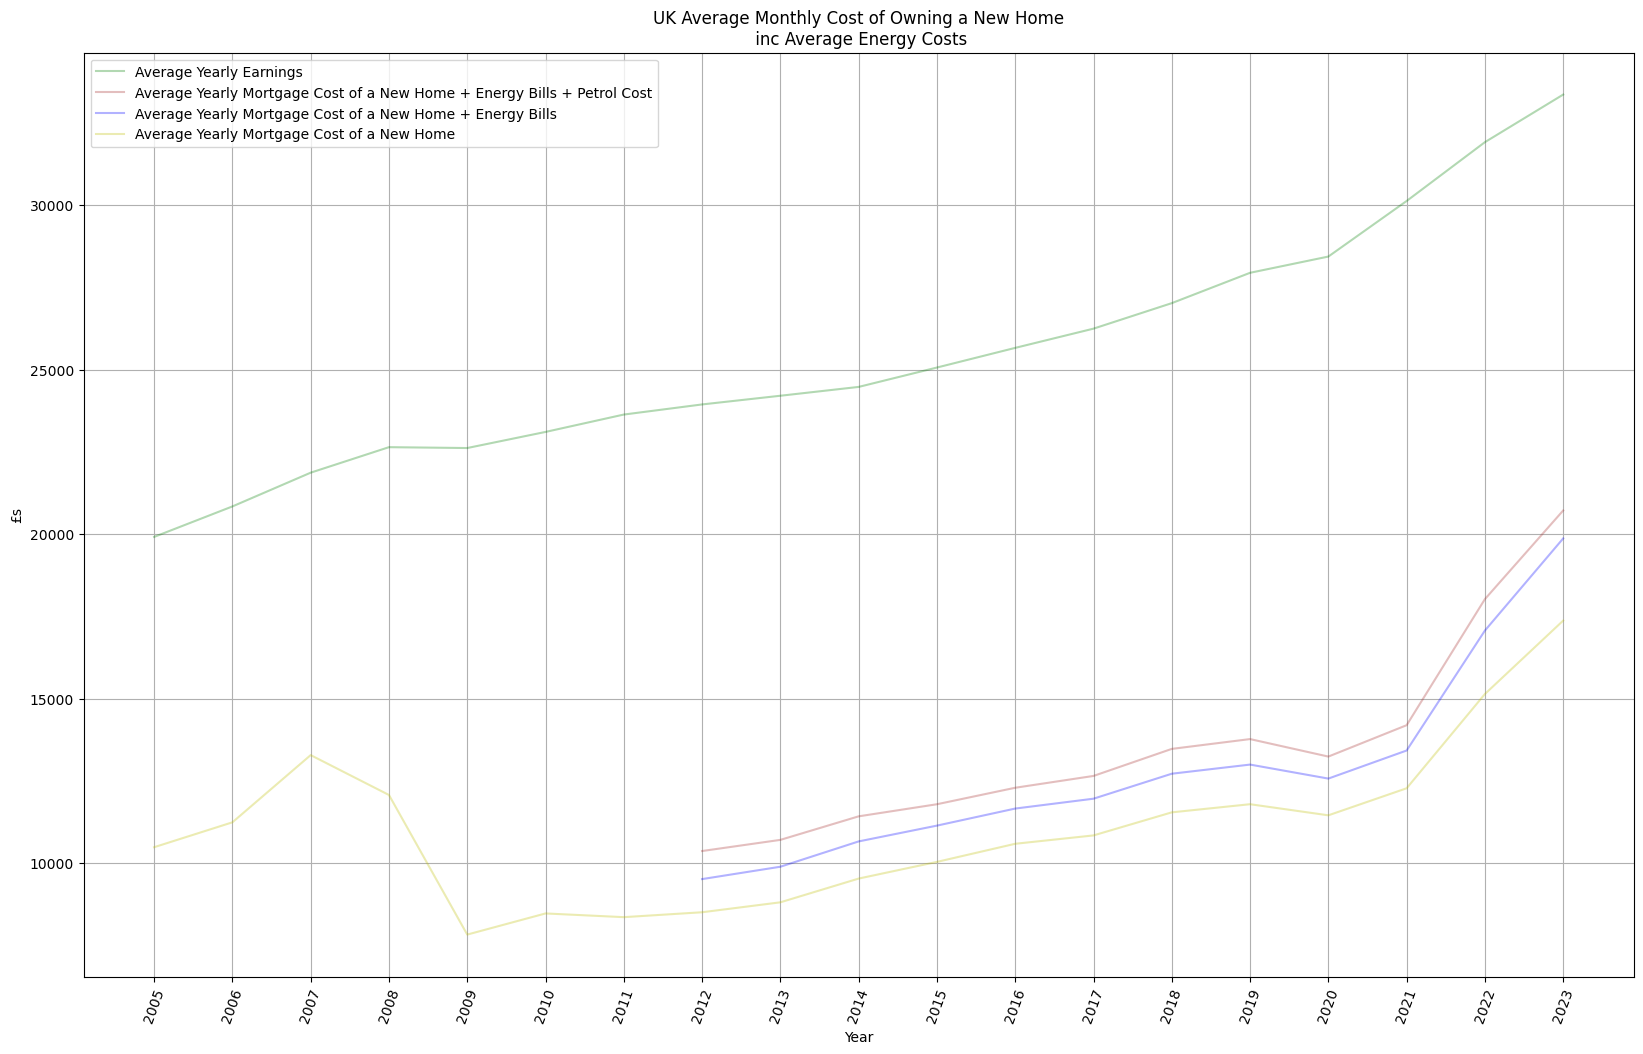

In [985]:
x_positions = range(len(df['Year']))

x_data_1 = df['Year']
y_data_1 = df['Average Yearly Pay']

x_date_2 = df['Year']
y_data_2 = df['Avg VR Mortgage Cost']

x_data_3 = df['Year']
y_data_3 = df['Petrol Spend£'] + df['Avg VR Mortgage Cost'] + df['Average Energy Bills']

# Data for average energy bills dataset starts from 2012
x_label_4 = df['Year'][df['Year'] >= 2012]
y_data_4 = df['Average Energy Bills'][df['Year'] >= 2012] + df['Avg VR Mortgage Cost'][df['Year'] >= 2012]

plt.figure()

# The graph plots
plt.plot(x_data_1, y_data_1, c='g', alpha=0.3, label= 'Average Yearly Earnings')
plt.plot(x_data_3, y_data_3, c='brown', alpha=0.3, label='Average Yearly Mortgage Cost of a New Home + Energy Bills + Petrol Cost')
plt.plot(x_label_4, y_data_4, c ='b', alpha=0.3, label='Average Yearly Mortgage Cost of a New Home + Energy Bills')
plt.plot(x_date_2, y_data_2, c='y', alpha=0.3, label='Average Yearly Mortgage Cost of a New Home')

# Required to assure that x_ticks aligns. 
years = range(2005, 2024)
plt.xticks(years, rotation=70)

plt.xticks(rotation=70)
plt.xlabel('Year')
plt.ylabel('£s')
plt.title('UK Average Monthly Cost of Owning a New Home\n inc Average Energy Costs')
plt.grid(True)
plt.legend()
plt.rcParams['figure.figsize'] = [20, 12]
plt.show()

Ok, so maybe the graph isn't that revelationary, however it does show a clear link between average yearly earnings and the average cost of owning a new home, which might be surprising or interesting to some. The cost of energy bills also seem to be on a slight trajectory in relation to average yearly earnings. Now to check if there is anything else interesting about the data. 

# Plotting the second graph

First the data required to plot the percentage changes between the years across the main variables: Average Yearly Pay, Average Mortgage Costs, Average Petrol Spend, and Average Energy Bills

In [986]:

# change_percentage is the function created at the beginnging of the code
av_perc_yearlypay = change_percentage(df, 'Average Yearly Pay')
av_perc_mortgage_cost = change_percentage(df, 'Avg VR Mortgage Cost')
av_perc_petrol_spend = change_percentage(df, 'Petrol Spend£')
av_perc_energy_bills = change_percentage(df, 'Average Energy Bills')

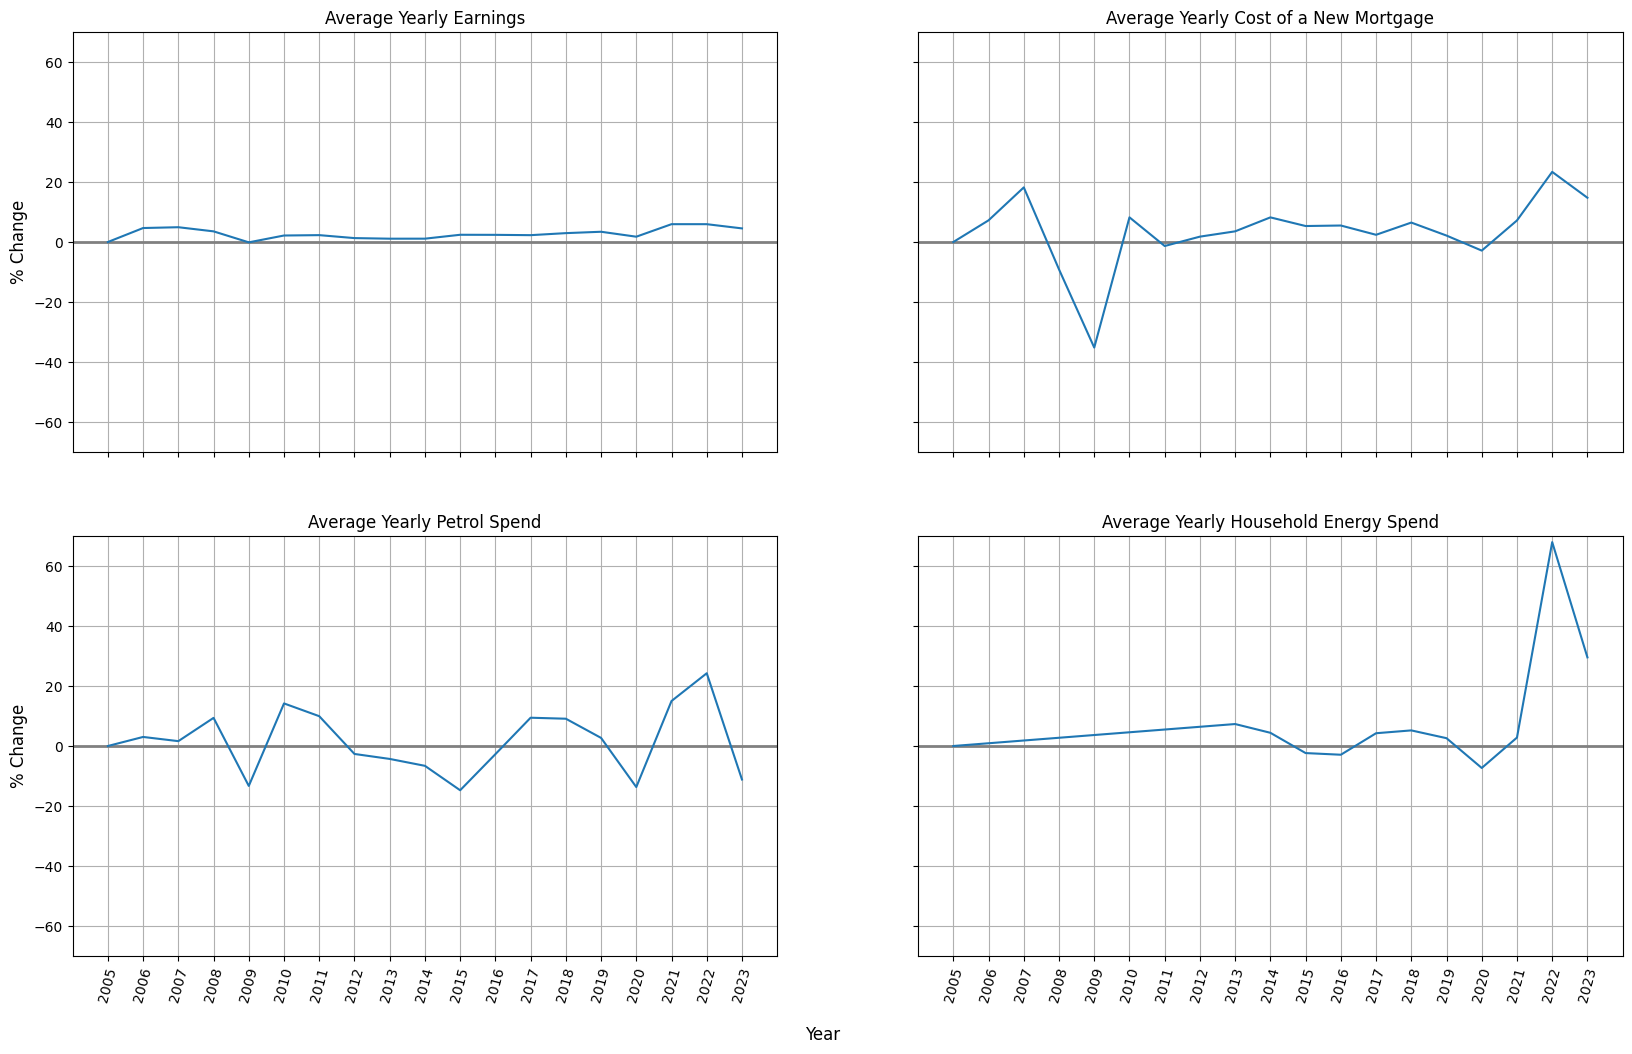

In [987]:
# Create subplots with Seaborn
fig, ((n1, n2), (n3, n4)) = plt.subplots(2, 2, sharex=True, sharey=True)

# Useful lists for the plots
dataframes = [av_perc_yearlypay, av_perc_mortgage_cost, av_perc_petrol_spend, av_perc_energy_bills]
y_ticks = np.arange(-60, 60, 2)
x_ticks = np.arange(2005, 2024, 1)
titles = ['Average Yearly Earnings', 'Average Yearly Cost of a New Mortgage', 'Average Yearly Petrol Spend', 'Average Yearly Household Energy Spend']
years = range(2005, 2024)

# For loop to set the x and y limits and ticks
for ax in [n1, n2, n3, n4]:
    # ax.set_yticks(y_ticks)
    ax.set_ylim(-70, 70)
    ax.set_xticks(x_ticks)
    ax.set_xlim(2004, 2024)    
    ax.set_xticklabels(years, rotation=75)
    ax.grid(True)

# For loop to set the appropriate title and an axhline.   
for i, ax in enumerate([n1, n2, n3, n4]):
    for e, title in enumerate(titles):
        if i == e: 
            ax.set_title(title, size=12)
            # ax.set_ylabel('% Change', size=12)
            ax.axhline(y=0, linewidth=2, color='grey')
            if ax in [n1, n3]:
                ax.set_ylabel('% Change', size=12)
                
fig.text(0.5, 0.04, 'Year', ha='center', size=12)

sns.lineplot(data=dataframes[0], x=dataframes[0].index, y='Average Yearly Pay', ax=n1)
sns.lineplot(data=dataframes[1], x=dataframes[1].index, y='Avg VR Mortgage Cost', ax=n2)
sns.lineplot(data=dataframes[2], x=dataframes[2].index, y='Petrol Spend£', ax=n3)
sns.lineplot(data=dataframes[3], x=dataframes[3].index, y='Average Energy Bills', ax=n4)

plt.rcParams['figure.figsize'] = [20, 12]

plt.show()

The result of the second graph is perhaps more interesting. 

✅ There was a similar increase in the yearly cost of a new home (mortgage payments) in 2007 in the UK (18.2% higher than 2006) before the last year on year average house price reduction in 2008 as there has been in 2022 (23.37% higher than 2021).

✅ There was also a similar slightly higher increase in average wages. Although relatively slight, there were two yearly increases in 2006 and 2007 of 4.66% and 4.93% as with 2021 and 2022 of 5.94% and 5.94%. The only reduction is year-on-year average wages were in 2009 of 0.11% and they have steadily risen between 1-4%.

The last recession before COVID was in 2008. If another recession follows in the next year then the correlation will be meaningful and something for further examination. 